# 問題設定

$y = 3 + 5*X_1 + 10*X_2 + 20*X_3 + ε$

で $X_1$ と $X_2$ に相関がある場合を考える

In [4]:
library(ggplot2)
library(gridExtra)
library(latex2exp)
library(dplyr)
library(tidyr)
library(foreach)
library(doParallel)

# ① 全ての説明変数を使う

### データ生成の設定

In [5]:
# 実験する相関係数のリスト
rho.list <- seq(0.1, 0.999, 0.01)
rho.len <- length(rho.list)

# サンプルサイズ：200
n <- 200

# 各相関係数に対して1,000回実験
K <- 1000

### 結果の格納場所

In [6]:
# 平均
mean_0 <- numeric(rho.len)
mean_1 <- numeric(rho.len)
mean_2 <- numeric(rho.len)
mean_3 <- numeric(rho.len)

# 分散
var_0 <- numeric(rho.len)
var_1 <- numeric(rho.len)
var_2 <- numeric(rho.len)
var_3 <- numeric(rho.len)

### 実験

In [7]:
# データを生成する関数

generate_data <- function(K, n, rho){
    # データは一括生成(for文遅い気がする)
    # n*K個の乱数をK行n列に配置し直す（1回の実験が行になっている）
    x1 <- matrix(runif(n * K, 0, 50), nrow = n, ncol = K)
    x2 <- matrix(runif(n * K, 0, 50), nrow = n, ncol = K)
    e1 <- matrix(runif(n * K, 0, 50), nrow = n, ncol = K)

    # 相関を持つデータを計算
    X1 <- sqrt(rho) * e1 + sqrt(1 - rho) * x1
    X2 <- sqrt(rho) * e1 + sqrt(1 - rho) * x2
    X3 <- matrix(runif(n * K, 0, 100), nrow = n, ncol = K)
    e  <- matrix(rnorm(n * K, 0, 25), nrow = n, ncol = K)

    # yを計算
    y <- 3 + 5 * X1 + 10 * X2 + 20 * X3 + e

    # 出力
    return(list(y=y, X1=X1, X2=X2, X3=X3))
}

In [8]:
library(foreach)
library(doParallel)

# 並列処理のコア数を設定（使用可能なコア数-1が一般的）
cores <- parallel::detectCores() - 1
cl <- makeCluster(cores)
registerDoParallel(cl)

set.seed(42)

# 並列処理で結果を計算
results <- foreach(i = seq_len(rho.len), .combine = 'rbind') %dopar% {
    rho <- rho.list[i]
    
    # データ作成
    df <- generate_data(K, n, rho)
    df_test <- generate_data(K, 1000, rho)
    
    # 各Kについての結果を保存
    local_results <- matrix(0, nrow = K, ncol = 6)
    
    for (k in seq_len(K)) {
        d_k <- data.frame(
            y = df$y[, k],
            X1 = df$X1[, k],
            X2 = df$X2[, k],
            X3 = df$X3[, k]
        )
        
        fit <- lm(y~., data=d_k)
        
        d_k.test <- data.frame(
            X1 = df_test$X1[, k],
            X2 = df_test$X2[, k],
            X3 = df_test$X3[, k]
        )
        
        y_test <- df_test$y[, k]
        y_pred <- predict(fit, d_k.test)
        mse <- mean((y_test - y_pred)^2)
        
        local_results[k, ] <- c(rho, fit$coefficients, mse)
    }
    
    local_results
}

# クラスターを閉じる
stopCluster(cl)

# 結果をデータフレームに変換
df_results <- as.data.frame(results)
colnames(df_results) <- c("rho", "coef_0", "coef_1", "coef_2", "coef_3", "error")

## 結果の確認

### - 平均のプロット

In [9]:
coef_mean <- df_results %>%
  group_by(rho) %>%
  summarise(mean_0 = mean(coef_0, na.rm = TRUE),
            mean_1 = mean(coef_1, na.rm = TRUE),
            mean_2 = mean(coef_2, na.rm = TRUE),
            mean_3 = mean(coef_3, na.rm = TRUE))

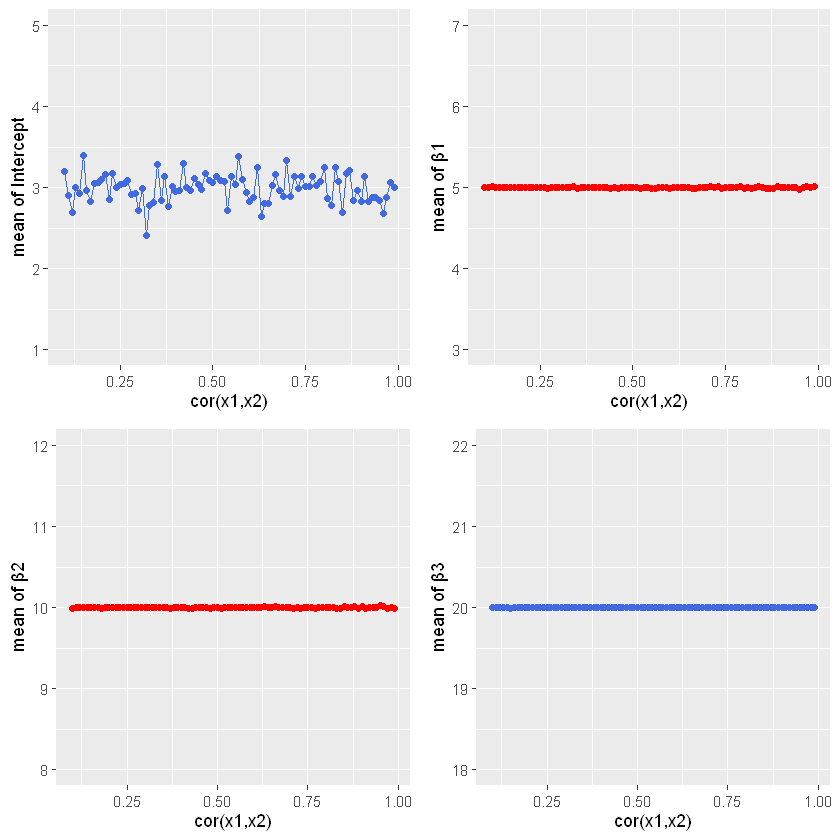

In [35]:
p.mean_0 <- ggplot(data=coef_mean, aes(x=rho, y=mean_0)) +
  geom_line(color="royalblue") +
  geom_point(color="royalblue") +
  ylim(1, 5) +
  ylab("mean of Intercept") +
  xlab("cor(x1,x2)") +
  theme(text = element_text(family = "sans"))

p.mean_1 <- ggplot(data=coef_mean, aes(x=rho, y=mean_1)) +
  geom_line(color = "red") +
  geom_point(color = "red") +
  ylim(3, 7) +
  ylab("mean of β1") +
  xlab("cor(x1,x2)") +
  theme(text = element_text(family = "sans"))

p.mean_2 <- ggplot(data=coef_mean, aes(x=rho, y=mean_2)) +
  geom_line(color = "red") +
  geom_point(color = "red") +
  ylim(8, 12) +
  ylab("mean of β2") +
  xlab("cor(x1,x2)") +
  theme(text = element_text(family = "sans"))

p.mean_3 <- ggplot(data=coef_mean, aes(x=rho, y=mean_3)) +
  geom_line(color = "royalblue") +
  geom_point(color = "royalblue") +
  ylim(18, 22) +
  ylab("mean of β3") +
  xlab("cor(x1,x2)") +
  theme(text = element_text(family = "sans"))

gridExtra::grid.arrange(p.mean_0, p.mean_1, p.mean_2, p.mean_3)

In [12]:
# png形式で出力
png("1_full-model/coefficient_means_plot.png", width = 10, height = 7, units = "in", res = 300)
gridExtra::grid.arrange(p.mean_0, p.mean_1, p.mean_2, p.mean_3)
dev.off()

pdf 
  2

### - 分散のプロット

In [13]:
coef_var <- df_results %>%
  group_by(rho) %>%
  summarise(
    var_0 = var(coef_0, na.rm = TRUE),
    var_1 = var(coef_1, na.rm = TRUE),
    var_2 = var(coef_2, na.rm = TRUE),
    var_3 = var(coef_3, na.rm = TRUE)
  )

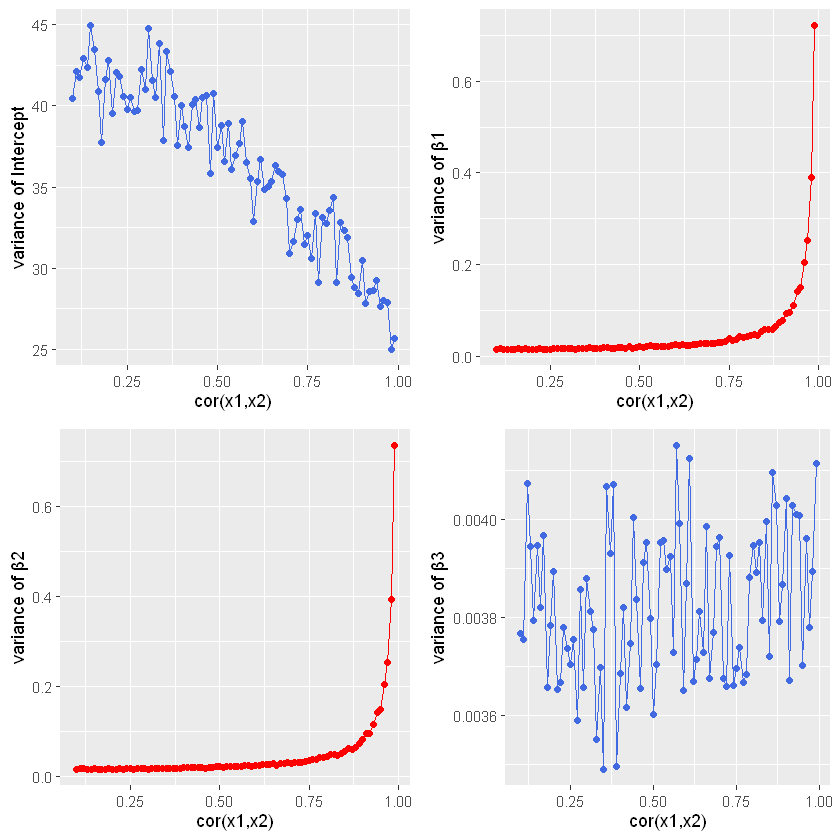

In [31]:
p.var_0 <- ggplot(data=coef_var, aes(x=rho, y=var_0)) +
  geom_line(color="royalblue") +
  geom_point(color="royalblue") +
  ylab("variance of Intercept") +
  xlab("cor(x1,x2)") 

p.var_1 <- ggplot(data=coef_var, aes(x=rho, y=var_1)) +
  geom_line(color = "red") +
  geom_point(color = "red") +
  ylab("variance of β1") +
  xlab("cor(x1,x2)")

p.var_2 <- ggplot(data=coef_var, aes(x=rho, y=var_2)) +
  geom_line(color = "red") +
  geom_point(color = "red") +
  ylab("variance of β2") +
  xlab("cor(x1,x2)")

p.var_3 <- ggplot(data=coef_var, aes(x=rho, y=var_3)) +
  geom_line(color = "royalblue") +
  geom_point(color = "royalblue") +
  ylab("variance of β3") +
  xlab("cor(x1,x2)") 

gridExtra::grid.arrange(p.var_0, p.var_1, p.var_2, p.var_3)

In [15]:
# png形式で出力
png("1_full-model/coefficient_variance_plot.png", width = 10, height = 7, units = "in", res = 300)
gridExtra::grid.arrange(p.var_0, p.var_1, p.var_2, p.var_3)
dev.off()

pdf 
  2

### - 期待予測誤差（MSEの平均）

In [16]:
Err <- df_results %>%
  group_by(rho) %>%
  summarise(Err = mean(error, na.rm = TRUE))

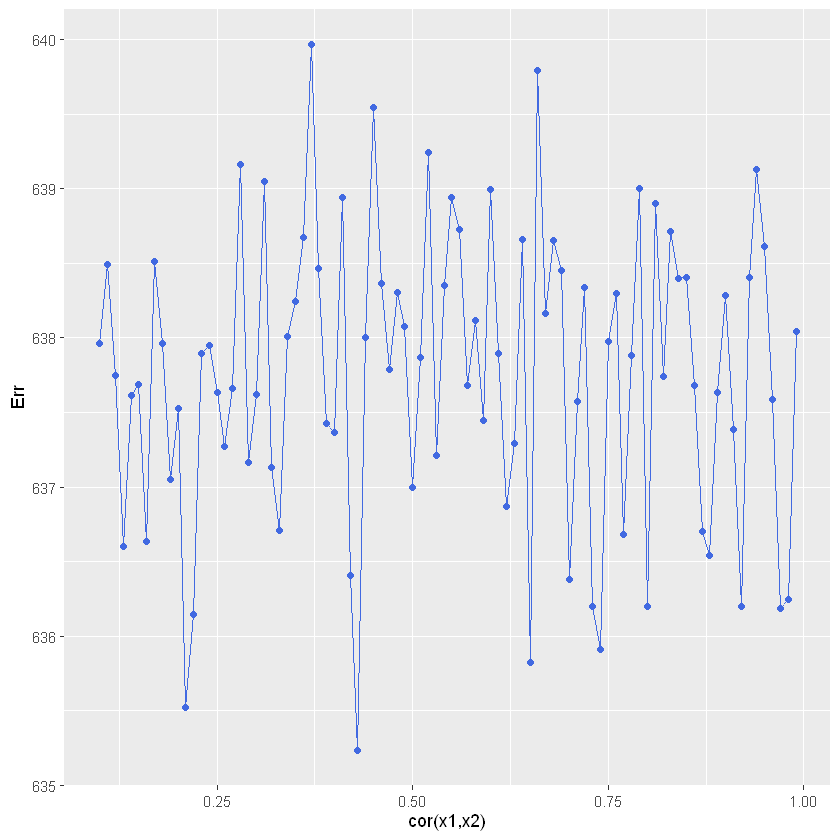

In [30]:
p.Err <- ggplot(data=Err, aes(x=rho, y=Err)) +
  geom_line(color="royalblue") +
  geom_point(color="royalblue") +
  ylab("Err") +
  xlab("cor(x1,x2)") 

p.Err

### - 回帰係数のMSE

In [24]:
MSE_beta <- df_results %>%
  group_by(rho) %>%
  summarise(MSE_beta0 = mean((coef_0 - 3)^2),
            MSE_beta1 = mean((coef_1 - 5)^2),
            MSE_beta2 = mean((coef_2 - 10)^2),
            MSE_beta3 = mean((coef_3 - 20)^2))

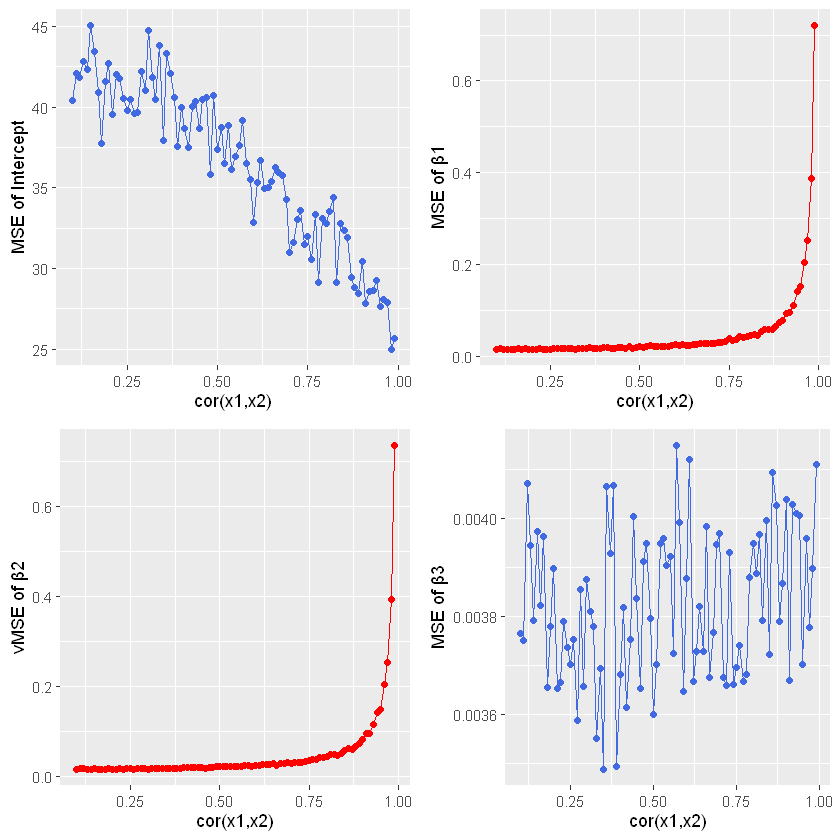

In [29]:
p.MSE_beta0 <- ggplot(data=MSE_beta, aes(x=rho, y=MSE_beta0)) +
  geom_line(color="royalblue") +
  geom_point(color="royalblue") +
  ylab("MSE of Intercept") +
  xlab("cor(x1,x2)") 

p.MSE_beta1 <- ggplot(data=MSE_beta, aes(x=rho, y=MSE_beta1)) +
  geom_line(color = "red") +
  geom_point(color = "red") +
  ylab("MSE of β1") +
  xlab("cor(x1,x2)")

p.MSE_beta2 <- ggplot(data=MSE_beta, aes(x=rho, y=MSE_beta2)) +
  geom_line(color = "red") +
  geom_point(color = "red") +
  ylab("vMSE of β2") +
  xlab("cor(x1,x2)")

p.MSE_beta3 <- ggplot(data=MSE_beta, aes(x=rho, y=MSE_beta3)) +
  geom_line(color = "royalblue") +
  geom_point(color = "royalblue") +
  ylab("MSE of β3") +
  xlab("cor(x1,x2)") 

gridExtra::grid.arrange(p.MSE_beta0, p.MSE_beta1, p.MSE_beta2, p.MSE_beta3)

### - 一致性の確認

In [27]:
# 実験する相関係数のリスト
rho09 <- 0.9
# サンプルサイズの最大50,000
n.list <- 50000

b0_consistent <- numeric(n.list)
b1_consistent <- numeric(n.list)
b2_consistent <- numeric(n.list)
b3_consistent <- numeric(n.list)

set.seed(42)
for(i in 20:n.list){
  x1 <- runif(i, 0, 50)
  x2 <- runif(i, 0, 50)
  e1 <- runif(i, 0, 50)
  
  X1 <- sqrt(rho09) * e1 + sqrt(1 - rho09) * x1
  X2 <- sqrt(rho09) * e1 + sqrt(1 - rho09) * x2
  X3 <- runif(i, 0, 100)
  e <- rnorm(i, 0, 25)
  
  y <- 3 + 5*X1 + 10*X2 + 20*X3 + e
  X <- cbind(X1, X2, X3)
  
  ln <- lm(y~X)
  b0_consistent[i] <- ln$coefficients[1]
  b1_consistent[i] <- ln$coefficients[2]
  b2_consistent[i] <- ln$coefficients[3]
  b3_consistent[i] <- ln$coefficients[4]
}


df0 <- data.frame(20:50000, b0_consistent[20:50000])
df1 <- data.frame(20:50000, b1_consistent[20:50000])
df2 <- data.frame(20:50000, b2_consistent[20:50000])
df3 <- data.frame(20:50000, b3_consistent[20:50000])
colnames(df0) <- c("n", "b0")
colnames(df1) <- c("n", "b1")
colnames(df2) <- c("n", "b2")
colnames(df3) <- c("n", "b3")

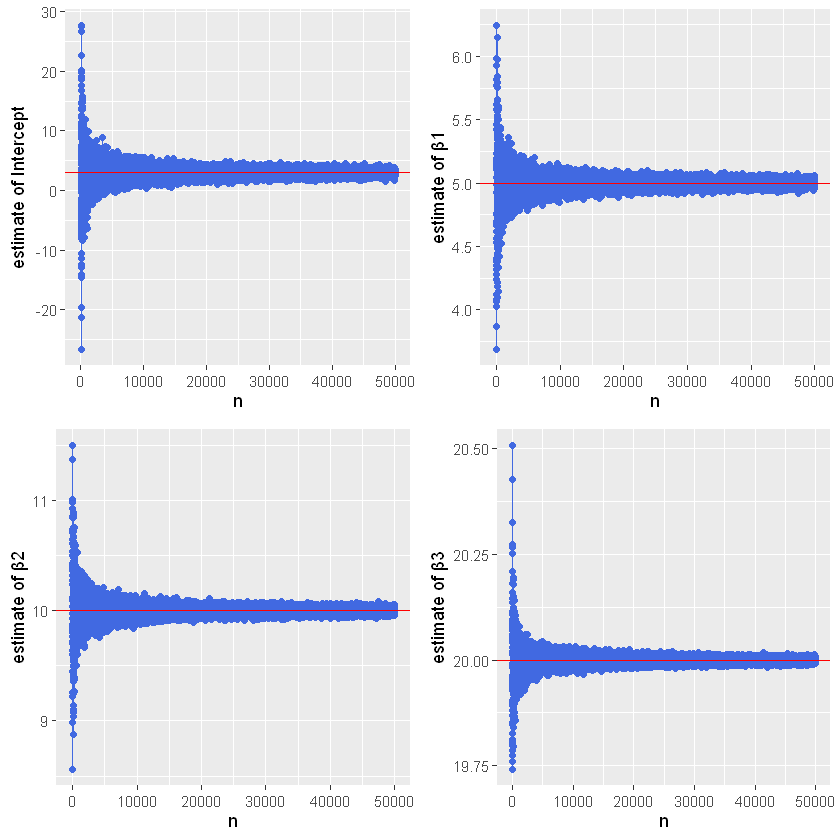

In [34]:
p0 <- ggplot(data=df0, aes(x=n, y=b0)) +
  geom_line(color = "royalblue") +
  geom_point(color = "royalblue") +
  geom_hline(yintercept = 3, color="red") +
  ylab("estimate of Intercept") +
  xlab("n")

p1 <- ggplot(data=df1, aes(x=n, y=b1)) +
  geom_line(color = "royalblue") +
  geom_point(color = "royalblue") +
  geom_hline(yintercept = 5, color="red") +
  ylab("estimate of β1") +
  xlab("n")

p2 <- ggplot(data=df2, aes(x=n, y=b2)) +
  geom_line(color = "royalblue") +
  geom_point(color = "royalblue") +
  geom_hline(yintercept = 10, color="red") +
  ylab("estimate of β2") +
  xlab("n")

p3 <- ggplot(data=df3, aes(x=n, y=b3)) +
  geom_line(color = "royalblue") +
  geom_point(color = "royalblue") +
  geom_hline(yintercept = 20, color="red") +
  ylab("estimate of β3") +
  xlab("n")

gridExtra::grid.arrange(p0, p1, p2, p3)